In [224]:
import gdown
gdown.download_folder("https://drive.google.com/drive/folders/1GVb24Y9mzAIMVccSqHQOVQSIoV7ufsWR?usp=sharing", quiet=True)

['/home/mehdi/elearn/DL/HWs/HW2/vars/unet_history.pt',
 '/home/mehdi/elearn/DL/HWs/HW2/vars/unet.pt']

In [111]:
import torch

def load(filename):
    return torch.load('vars/' + filename + '.pt', map_location=torch.device('cpu'))

def save(object, filename):
    filename = 'vars/' + filename + '.pt'
    if isinstance(object, torch.nn.Module):
        torch.save(object.state_dict(), filename)
    else:
        torch.save(object, filename)

# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Mehdi Jamalkhah

*SID:* ...

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

### Google Colab Setup

In [32]:
from google.colab import drive
drive.mount('/content/drive')

In [33]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL/HW2'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
os.chdir(GOOGLE_DRIVE_PATH)
print(os.listdir('./'))

In [8]:
import torch
import torchvision
from torchvision import transforms
import numpy as np

## Device

Set device to work with (GPU or CPU)

In [9]:
CUDA = 'cuda'
device = CUDA if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [10]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

In [114]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = tensor.clone()
        if gray:
            coeff = torch.tensor(coeff)
            mean = sum(self.mean * coeff)
            std = sum(self.std * coeff)
            tensor = tensor * std + mean
        else:
            for i in range(len(self.mean)):
                tensor[i, :, :] = tensor[i, :, :] * self.std[i] + self.mean[i]
                
        return torch.clamp(tensor, min=0, max=255)

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

In [13]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

batch_size = 128

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [14]:
images = torch.stack([trainset[i][0] for i in range(len(trainset))])
labels = torch.tensor([trainset[i][1] for i in range(len(trainset))])

In [112]:
import matplotlib.pyplot as plt

def imshow(img):
    if img.shape[0] == 1:
        img = norminv(img, gray=True)
        plt.imshow(img.view(img.shape[1], img.shape[2]), cmap='gray')
    else:
        img = norminv(img)  
        plt.imshow(img.permute(1, 2, 0))
    plt.axis(False)

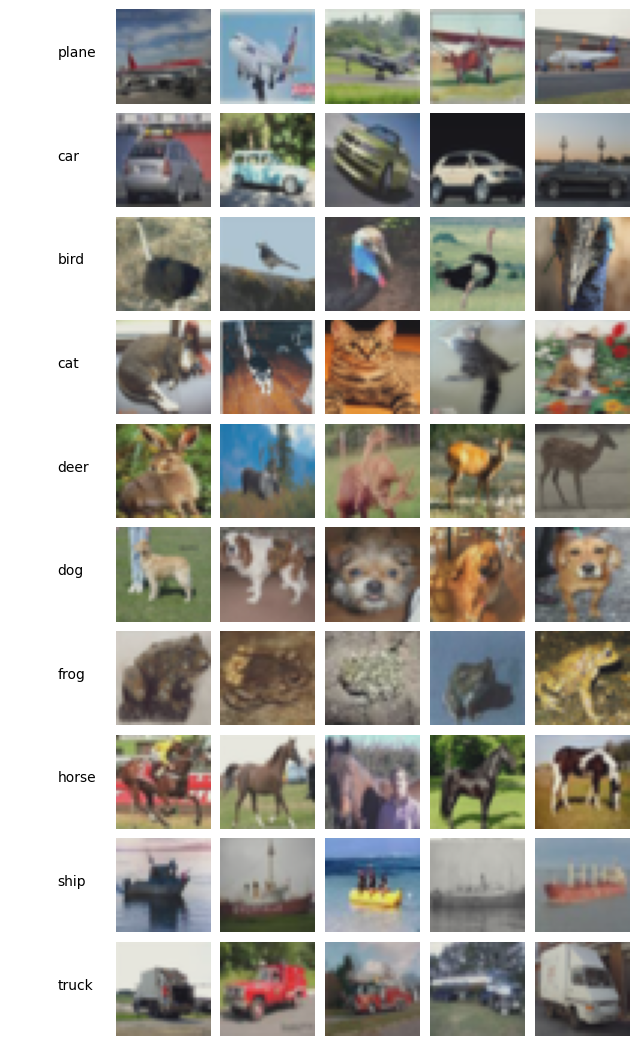

In [293]:


sample_size = 5
plt.figure(figsize=(8, 40/3))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, label in enumerate(classes):
    # title
    plt.subplot(10, 6, 6 * i + 1)
    plt.plot([])
    plt.annotate(label, [0, 0])
    plt.axis(False)
    
    bool_idx = (labels == i)
    indices = np.random.choice(torch.arange(0, len(bool_idx))[bool_idx] , size=sample_size)
    
    for k, img in enumerate(images[indices]):
        plt.subplot(10, 6, 6 * i + k + 2)
        imshow(img)

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [16]:
import torch.nn as nn

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None,stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNetLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1) -> None:
        super(ResNetLayer, self).__init__()

        identity_downsample = None
        if stride != 1:
            identity_downsample =  nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels)
            )

        self.block1 = ResNetBlock(in_channels, out_channels, identity_downsample, stride=stride)
        self.block2 = ResNetBlock(out_channels, out_channels)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return x


class ResNet18(torch.nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResNetLayer(64, 64)
        self.layer2 = ResNetLayer(64, 128, stride=2)
        self.layer3 = ResNetLayer(128, 256, stride=2)
        self.layer4 = ResNetLayer(256, 512, stride=2)

        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgPool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [17]:
net = ResNet18().to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [18]:
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [19]:
import tqdm
from time import time

In [20]:
def correct(output, target):
    _, predicted = output.max(1)
    return predicted.eq(target).sum().item()

In [21]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    net.train()

    total_loss = 0.0
    corrects = 0
    total = 0

    for batch, labels in dataloader:
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()
        output = net(batch)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total += labels.size(0)
        corrects += correct(output, labels)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * corrects / total

    return avg_loss, accuracy

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()

    total_loss = 0.0
    corrects = 0
    total = 0

    if test_mode:
      incorrect_images = torch.tensor([]).to(device)
      incorrect_ys = torch.tensor([]).to(device)
      incorrect_pred_ys = torch.tensor([]).to(device)

    with torch.no_grad():
        for batch, labels in dataloader:
            batch, labels = batch.to(device), labels.to(device)

            outputs = net(batch)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            corrects += predicted.eq(labels).sum().item()

            if test_mode:
              bool_inx = ~predicted.eq(labels)
              incorrect_images = torch.concatenate([incorrect_images, batch[bool_inx]])
              incorrect_ys = torch.concatenate([incorrect_ys, labels[bool_inx]])
              incorrect_pred_ys = torch.concatenate([incorrect_pred_ys, predicted[bool_inx]])

    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * corrects / total

    if test_mode:
      return avg_loss, accuracy, incorrect_images, incorrect_ys, incorrect_pred_ys
    return avg_loss, accuracy


In [22]:
epochs = 8
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

if device == CUDA:
    for e in range(epochs):
        train_loss, train_acc = train_epoch(net, criterion, optimizer, scheduler, trainloader)
        val_loss, val_acc = eval_epoch(net, criterion, valloader)
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"(Epoch {e + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

    save(net, 'net')
    save(history, 'history')
else:
    net.load_state_dict(load('net'))
    history = load('history')

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

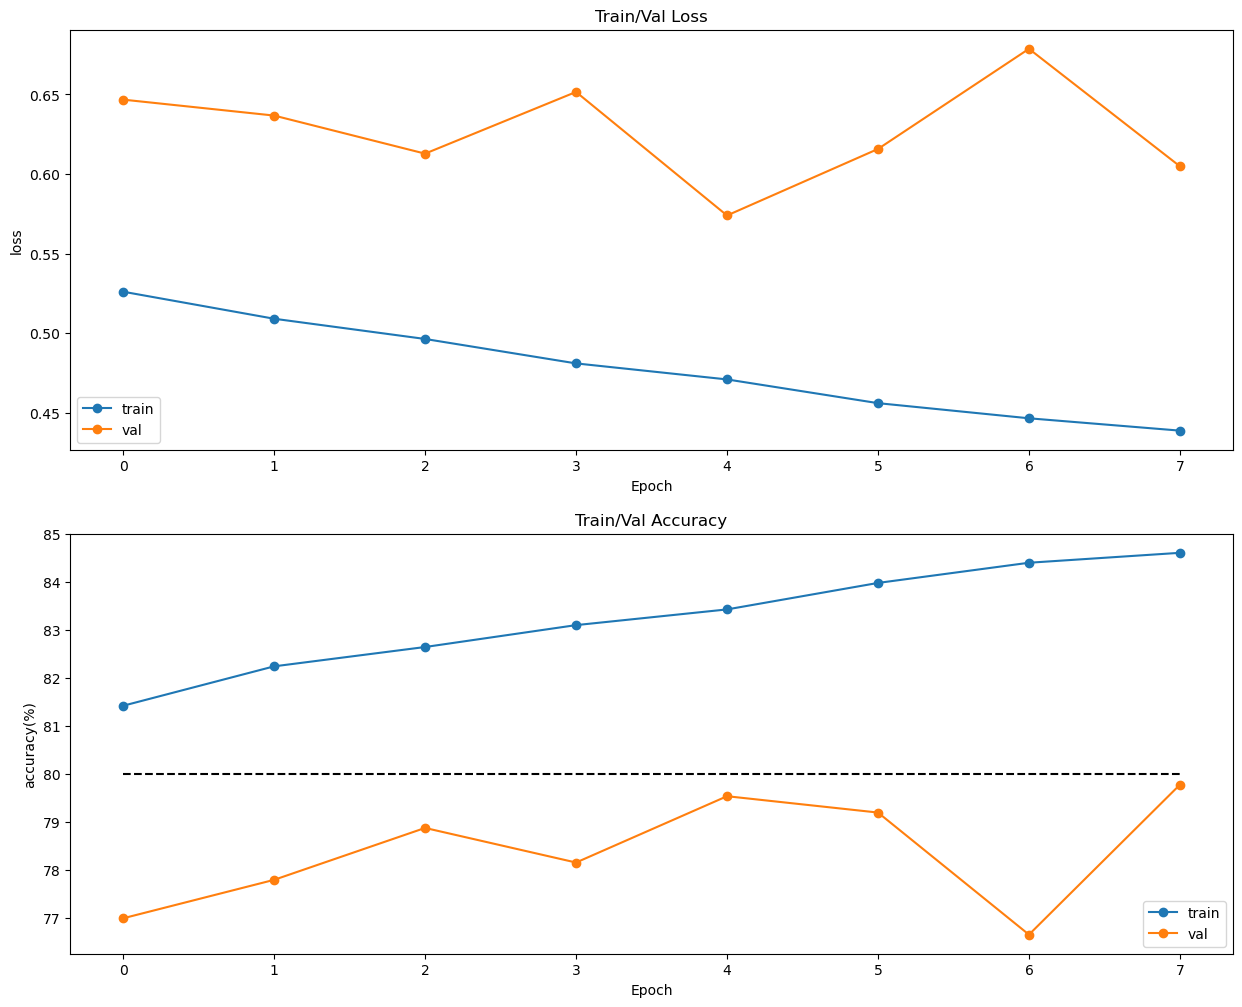

In [23]:
import matplotlib.pyplot as plt

def plot_loss_history(history):
    plt.title('Train/Val Loss')
    plt.plot(history['train_loss'], '-o', label='train')
    plt.plot(history['val_loss'], '-o', label='val')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(loc='lower left')

def plot_acc_history(history):
    plt.title('Train/Val Accuracy')
    plt.plot(history['train_acc'], '-o', label='train')
    plt.plot(history['val_acc'], '-o', label='val')
    plt.plot([80] * len(history['train_acc']), 'k--')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy(%)')
    plt.legend(loc='lower right')
    plt.gcf().set_size_inches(15, 12)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plot_loss_history(history)
plt.subplot(2, 1, 2)
plot_acc_history(history)

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [41]:
test_loss, test_acc, incorrects, y, pred_y = eval_epoch(net, criterion, testloader, test_mode=True)
print(f"train loss:{test_loss: .4f}; test acc:{test_acc: .2f}%;")

train loss: 0.6031; test acc: 80.02%;


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

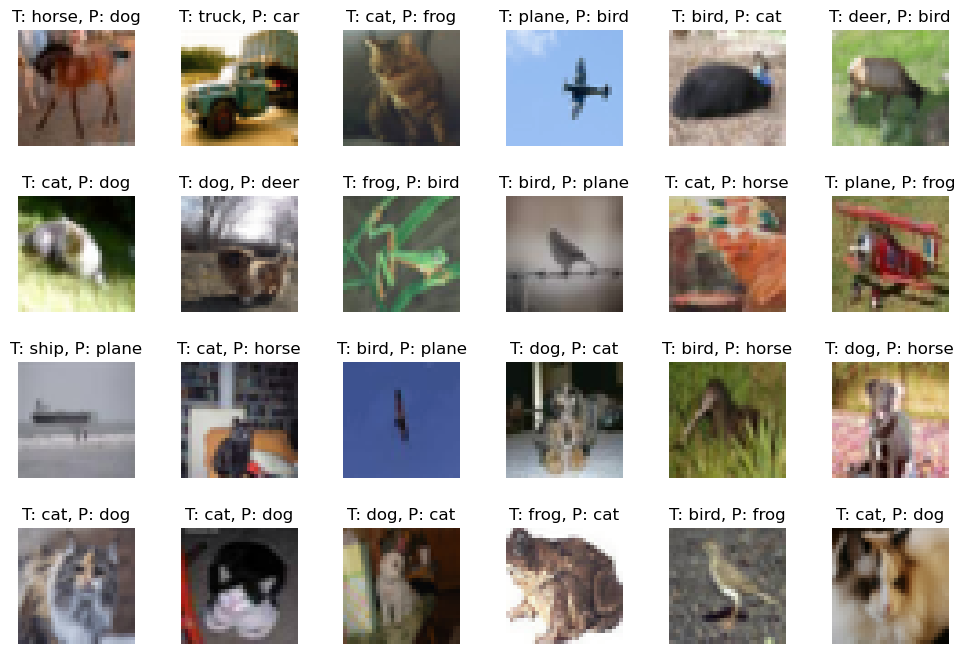

In [42]:
indexes = np.random.randint(0 , len(incorrects), 24)
plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, idx in enumerate(indexes):
    plt.subplot(4, 6, i + 1)
    imshow(incorrects[idx])
    plt.title(f"T: {classes[int(y[idx])]}, P: {classes[int(pred_y[idx])]}")

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [51]:
truncated_net = nn.Sequential(*list(net.children())[:-1]).to(device)
if device == CUDA:
    dataloader = DataLoader(initial_trainset, batch_size=50000, shuffle=False, num_workers=2)
    batch, labels = next(iter(dataloader))
    batch, labels = batch.to(device), labels.to(device)

    train_space = truncated_net(batch)
    
    save(train_space, 'resnet_feature_space')
else:
    train_space = load('resnet_feature_space')
    
train_space.shape

torch.Size([2000, 512, 1, 1])

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

In [52]:
num_sample = 5
indexes = np.random.randint(0, len(testset), len(testset))
sample_tests = []
for idx in indexes:
    image, label = testset[idx]
    if torch.argmax(net(image.view(1, *image.shape))) == label:
        sample_tests.append(image)
    if len(sample_tests) == num_sample:
        break
        
sample_tests = torch.stack(sample_tests)

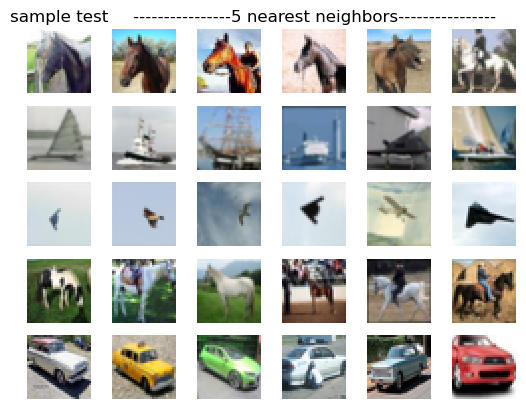

In [53]:
test_space = truncated_net(sample_tests)

for i, test in enumerate(test_space):
    plt.subplot(5, 6, 6 * i + 1)
    imshow(sample_tests[i])
    
    if i==0:
        plt.title("sample test")
        
    _, indices = torch.topk(-torch.linalg.norm(train_space - test, dim=1).view(train_space.shape[0]), k=5)
    for k, idx in enumerate(indices):
        image, label = initial_trainset[idx]
        plt.subplot(5, 6, 6 * i + k + 2)
        imshow(image)
        
        if i==0 and k==2:
            plt.title("----------------5 nearest neighbors----------------")

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


In [71]:
from sklearn.manifold import TSNE
indices = np.random.randint(0, len(train_space), 2000)
train_space = train_space[indices]
labels = labels[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(train_space.reshape(train_space.shape[0], -1).detach().numpy())

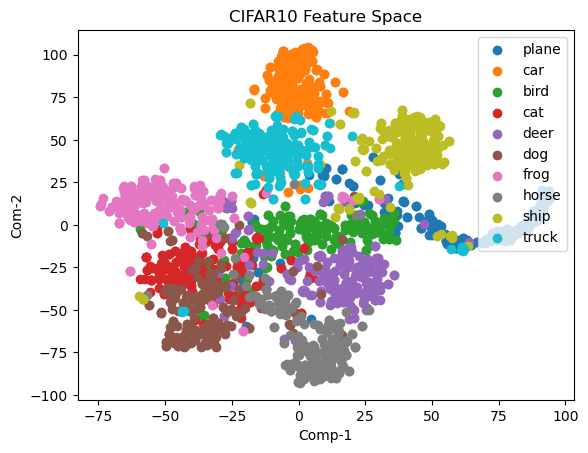

In [81]:
for i, c in enumerate(classes):
    plt.scatter(reduced_space[labels==i, 0], reduced_space[labels==i, 1], label=c)
plt.xlabel('Comp-1')
plt.ylabel('Com-2')
plt.title('CIFAR10 Feature Space')
plt.legend()
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [85]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [87]:
class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
        self.data = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index][0]
        bw_image = 0.3 * image[0] + 0.59 * image[1] + 0.11 * image[2]
        return bw_image.view(1, image.shape[1], image.shape[2]), image

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [89]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [90]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [91]:
from torch.utils.data import random_split
trainset, valset = random_split(initial_trainset, [45000, 5000])

In [92]:
batch_size = 128

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

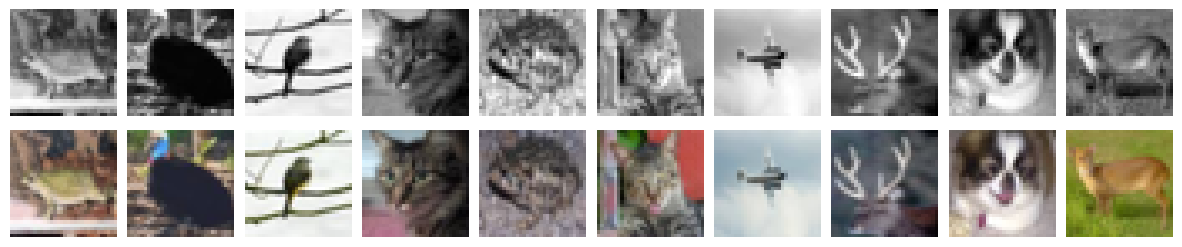

In [117]:
indexes = np.random.randint(0, len(trainset), 10)

plt.figure(figsize=(15, 3))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, idx in enumerate(indexes):
    bw_image, image = trainset[idx]
    plt.subplot(2, 10, i + 1)
    imshow(bw_image)
    plt.subplot(2, 10, 11 + i)
    imshow(image)

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [118]:

import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)

        return x


class TransConvBlock(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(TransConvBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, skip_input):
        pass

class colorizationNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(colorizationNet, self).__init__()
        self.dwn_conv1 = ConvBlock(in_channels, 64)
        self.dwn_conv2 = ConvBlock(64, 128)
        self.dwn_conv3 = ConvBlock(128, 256)
        self.dwn_conv4 = ConvBlock(256, 512)
        self.dwn_conv5 = ConvBlock(512, 1024)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(1024)

        self.trans_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.trans_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.trans_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.trans_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.up_conv1 = ConvBlock(1024, 512)
        self.up_conv2 = ConvBlock(512, 256)
        self.up_conv3 = ConvBlock(256, 128)
        self.up_conv4 = ConvBlock(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.dwn_conv1(x)
        x2 = self.max_pool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.max_pool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.max_pool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.max_pool(x7)
        x9 = self.dwn_conv5(x8)

        x = self.bn(x9)

        x = self.trans_conv1(x)
        x = torch.cat([x7, x], 1)
        x = self.up_conv1(x)

        x = self.trans_conv2(x)
        x = torch.cat([x5, x], 1)
        x = self.up_conv2(x)

        x = self.trans_conv3(x)
        x = torch.cat([x3, x], 1)
        x = self.up_conv3(x)

        x = self.trans_conv4(x)
        x = torch.cat([x1, x], 1)
        x = self.up_conv4(x)

        x = self.out(x)

        return x


## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [119]:
net = colorizationNet(1, 3).to(device)

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)

In [122]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    net.train()

    total_loss = 0.0

    for batch, labels in dataloader:
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()
        output = net(batch)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()

    total_loss = 0.0

    with torch.no_grad():
        for batch, labels in dataloader:
            batch, labels = batch.to(device), labels.to(device)

            outputs = net(batch)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [123]:
epochs = 2
history = {'train_loss':[], 'val_loss':[]}

if device == CUDA:
    for e in range(epochs):
        train_loss = train_epoch(net, criterion, optimizer, trainloader)
        val_loss = eval_epoch(net, criterion, valloader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"(Epoch {e + 1} / {epochs}) train loss:{train_loss: .4f}; val loss:{val_loss: .4f};")

    save(net, 'unet')
    save(history, 'unet_history')
else:
    net.load_state_dict(load('unet'))
    history = load('unet_history')

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

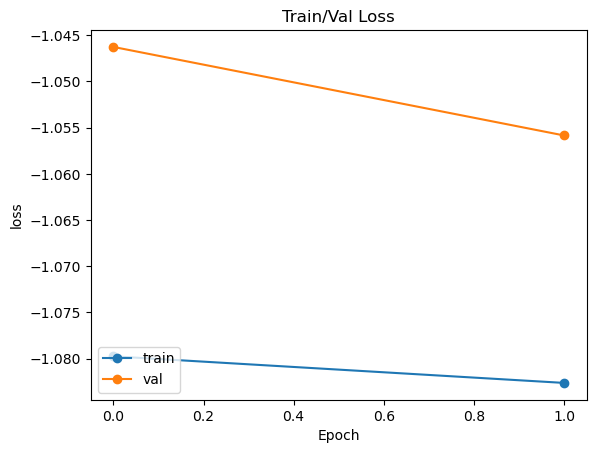

In [124]:
plot_loss_history(history)

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [125]:
testset = BlackAndWhiteCIFAR10(train=False, root='./data', download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


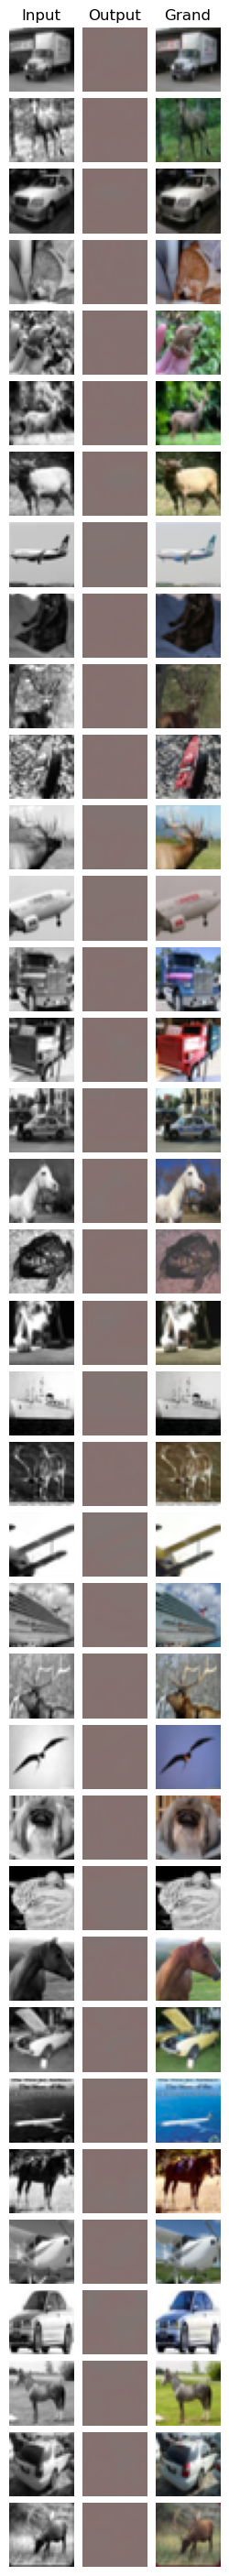

In [132]:
import numpy as np
sample_num = 36

np.random.seed(42)
indexes = np.random.randint(0, len(testset), sample_num)

with torch.no_grad():
  input_batch = torch.stack([testset[idx][0] for idx in indexes]).to(device)
  grand_batch = torch.stack([testset[idx][1] for idx in indexes]).to(device)
  output_batch = net(input_batch)

plt.figure(figsize=(3, 36))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, (input, grand, output) in enumerate(zip(input_batch, grand_batch, output_batch)):
  plt.subplot(36, 3, 3 * i + 1)
  plt.imshow(input.cpu().view(input.shape[1], input.shape[1]), cmap='gray')
  plt.axis(False)
  plt.subplot(36, 3, 3 * i + 2)
  plt.imshow(norminv(output).permute(1, 2, 0))
  plt.axis(False)
  plt.subplot(36, 3, 3 * i + 3)
  plt.imshow(norminv(grand).permute(1, 2, 0))
  plt.axis(False)
  
  if i == 0:
    plt.subplot(36, 3, 3 * i + 1)
    plt.title('Input')
    plt.subplot(36, 3, 3 * i + 2)
    plt.title('Output')
    plt.subplot(36, 3, 3 * i + 3)
    plt.title('Grand')
  